In [128]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
from pathlib import Path

import cv2
import skimage as sk
import skimage.io as skio

In [129]:
from main import *
from harris import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [130]:
SAMPLE_NUMBER = 6
image_dir = Path(f'./samples/{SAMPLE_NUMBER}')
IMAGES = [x for x in sorted(image_dir.iterdir()) if x.suffix == ".jpg"]

(1008, 756, 3)

dtype('uint8')

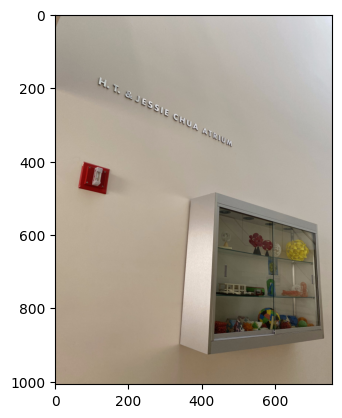

In [131]:
im = skio.imread(IMAGES[0])
display(im.shape)
display(im.dtype)
plt.imshow(im)

In [132]:
# make image grayscale
response, points = get_harris_corners(im)
points.shape

(2, 14570)

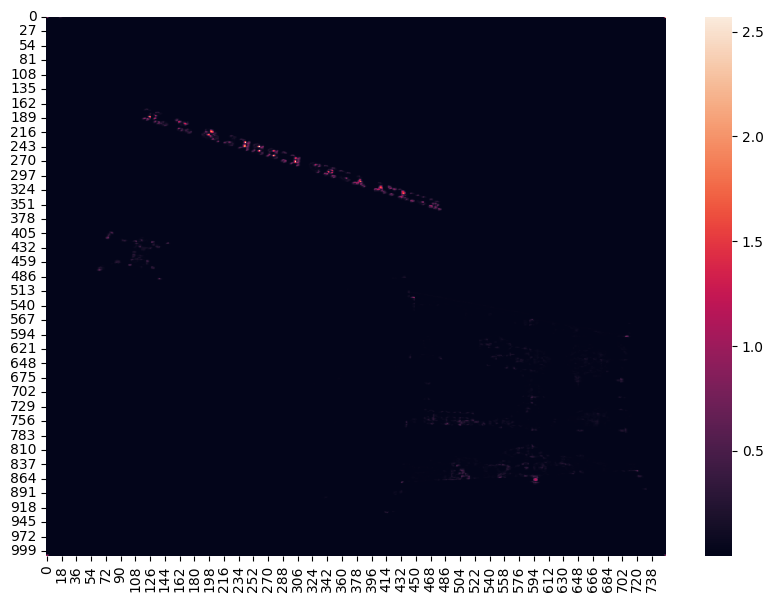

In [133]:
import seaborn as sns
plt.figure(figsize=(10, 7))
sns.heatmap(response)
plt.show()

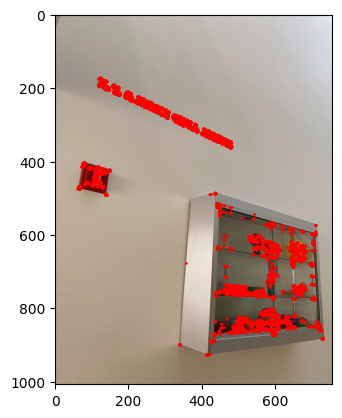

In [134]:
plt.imshow(im)
plt.plot(points[1], points[0], 'r.', markersize=1)

In [135]:
def compute_mop(im, point):
    x, y = point
    patch = im[x-20:x+20, y-20:y+20]
    patch = sk.transform.rescale(patch, 1/5, anti_aliasing=True)
    patch = (patch - np.mean(patch))/np.std(patch)
    patch = patch.flatten()
    return patch

def get_mops(im, points):
    """
    get the mops descriptors for the points in the image
    """
    # convert to grayscale
    im = sk.color.rgb2gray(im)
    patches = []
    for point in points.T:
        patches.append(compute_mop(im, point))

    return np.array(patches)

(64,)

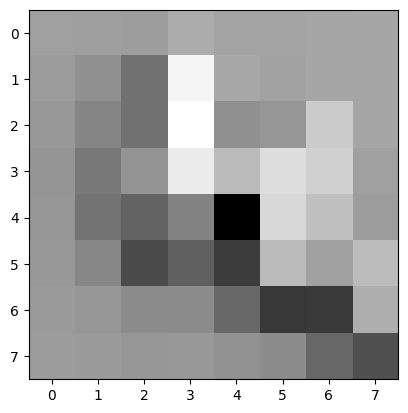

In [136]:
mop = compute_mop(im, points[:, 200])
display(mop.shape)
plt.imshow(mop.reshape(8, 8), cmap='gray')

(1008, 756, 3)

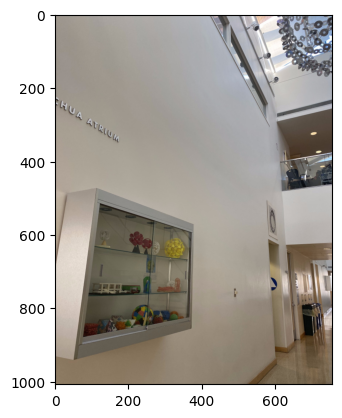

In [137]:
im2 = skio.imread(IMAGES[1])
display(im2.shape)
plt.imshow(im2)

In [138]:
response, points2 = get_harris_corners(im2)
points2.shape

(2, 34019)

In [139]:
patches1 = get_mops(im, points)
patches2 = get_mops(im2, points2)

In [140]:
def match_patches(patches1, patches2, threshold=0.5):
    """
    match the patches in patches1 to the patches in patches2
    """
    dists = dist2(patches1, patches2)
    
    nearest_dist_index = np.argmin(dists, axis=1)
    nearest_dist = dists[np.arange(dists.shape[0]), nearest_dist_index]
    second_nearest_dist = np.partition(dists, 2, axis=1)[:, 1]

    ratios = nearest_dist / second_nearest_dist
    out = np.where(ratios < threshold)[0]

    matched_points1 = points[:, out]
    matched_points2 = points2[:, nearest_dist_index[out]]
    
    return matched_points1, matched_points2

In [141]:
pt1, pt2 = match_patches(patches1, patches2, threshold=0.4)

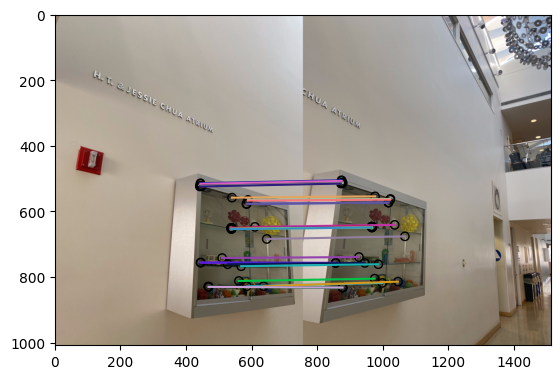

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=1)
sk.feature.plot_matches(ax, im, im2, pt1.T, pt2.T, np.array([(i, i) for i in range(len(pt1.T))]))

In [123]:
def transform_points(h, pt):
    """
    transform the points using the homography matrix
    """
    transformed = h @ pt
    transformed /= transformed[-1]
    return transformed

def homogenize_points(pt):
    """
    homogenize the points
    """
    return np.vstack((pt, np.ones(pt.shape[1])))

def ransac(pt1, pt2, threshold=20, n_iter=5000):
    """
    run ransac on the points to find the best homography
    """
    best_h = None
    best_inliers = 0

    pt1 = homogenize_points(pt1[::-1])
    pt2 = homogenize_points(pt2[::-1])

    for _ in range(n_iter):
        # pick 4 random points
        idx = np.random.choice(np.arange(pt1.shape[1]), 4)
        p1 = pt1[:, idx]
        p2 = pt2[:, idx]

        h = computeH(p1[:2].T, p2[:2].T)
        transformed = transform_points(h, pt2)
        error = np.linalg.norm(pt1 - transformed, axis=0)
        inliers = np.sum(error < threshold)
        
        if inliers > best_inliers:
            best_inliers = inliers
            best_h = h

    return best_h

In [124]:
H = computeH(pt1[::-1, :].T, pt2[::-1, :].T)
H

array([[ 6.24273047e-01,  3.54372917e-02,  3.15954965e+02],
       [-2.59389042e-01,  8.34696567e-01,  8.22652969e+01],
       [-4.21452830e-04, -6.09810545e-05,  1.00000000e+00]])

In [125]:
H = ransac(pt1, pt2, threshold=20, n_iter=10000)
H

array([[ 5.98844426e-01,  2.38242408e-02,  3.19082600e+02],
       [-2.69283299e-01,  8.03931433e-01,  9.23901198e+01],
       [-4.44360127e-04, -8.08273509e-05,  1.00000000e+00]])

In [126]:
images = [im, im2]
Hs = [np.eye(3), H]
pano = stitch_images(get_warped_images(images, Hs))

[(0, 0, 756, 1008), (319, -168, 1367, 1201)]
(0, -168) (1367, 1369)


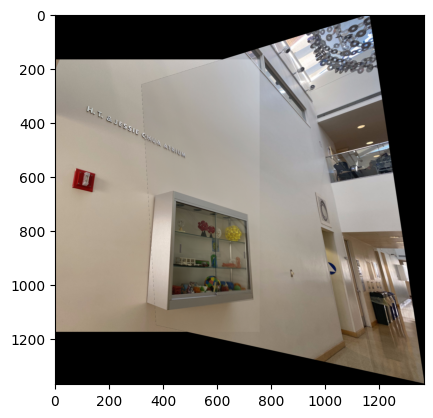

In [127]:
plt.imshow(pano)